# Week 9: Unsupervised Learning - PCA, Clustering, Anomaly Detection

---

## 🎯 What You'll Learn This Week

Unsupervised learning discovers hidden patterns without labeled data. In finance, it's crucial for regime detection, factor discovery, and anomaly identification.

**Key Concepts:**
- PCA for dimensionality reduction and factor discovery
- K-Means clustering for market regime identification
- Hierarchical clustering for asset grouping
- Anomaly detection for unusual market conditions

**Why This Matters:**
Markets don't come with "regime" labels. Unsupervised methods help us discover structure in data and identify unusual conditions for risk management.

---

## Table of Contents
1. Principal Component Analysis (PCA)
2. K-Means Clustering
3. Hierarchical Clustering
4. Anomaly Detection

---

In [1]:
# Standard imports and data loading
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Standard 5 equities + additional for clustering
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'JPM', 'GS', 'BAC', 'XOM', 'CVX', 'SPY']

# Fetch 5 years of data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading market data...")
data = yf.download(TICKERS, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} days of data for {len(TICKERS)} tickers")
print(f"📅 Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(returns.tail())

📥 Downloading market data...
✅ Loaded 1255 days of data for 11 tickers
📅 Date range: 2021-01-25 to 2026-01-22
Ticker          AAPL      AMZN       BAC       CVX     GOOGL        GS  \
Date                                                                     
2026-01-15 -0.006732  0.006465  0.002096 -0.006458 -0.009111  0.046308   
2026-01-16 -0.010379  0.003947  0.007226  0.000602 -0.008354 -0.014203   
2026-01-20 -0.034556 -0.033958 -0.016424 -0.005774 -0.024242 -0.019366   
2026-01-21  0.003851  0.001342 -0.000576  0.008651  0.019814  0.010219   
2026-01-22  0.010808  0.016158  0.019589  0.002399  0.010658  0.017502   

Ticker           JPM      META      MSFT       SPY       XOM  
Date                                                          
2026-01-15  0.004515  0.008578 -0.005921  0.002723 -0.008218  
2026-01-16  0.010380 -0.000886  0.007007 -0.000838  0.005885  
2026-01-20 -0.031139 -0.026006 -0.011612 -0.020357  0.004388  
2026-01-21 -0.002312  0.014633 -0.022903  0.011541  0.02

---

## 1. Principal Component Analysis (PCA)

### 🤔 Simple Explanation

PCA finds the main "directions" of variation in your data. Instead of looking at 50 correlated stock returns, you can look at 3-5 uncorrelated "principal components" that explain most of the variance.

**The Algorithm:**
1. Center data: $\tilde{X} = X - \bar{X}$
2. Compute covariance matrix
3. Find eigenvectors (directions) and eigenvalues (importance)
4. Project data onto top k eigenvectors

### Finance Application: Statistical Factors
- PC1 usually ≈ Market factor (all stocks move together)
- PC2-3 often ≈ Sector or style factors

PCA Results - Stock Return Factors

Variance explained by top components:
  PC1: 50.7% (cumulative: 50.7%)
  PC2: 18.5% (cumulative: 69.2%)
  PC3: 9.9% (cumulative: 79.1%)
  PC4: 4.8% (cumulative: 83.8%)
  PC5: 3.7% (cumulative: 87.5%)


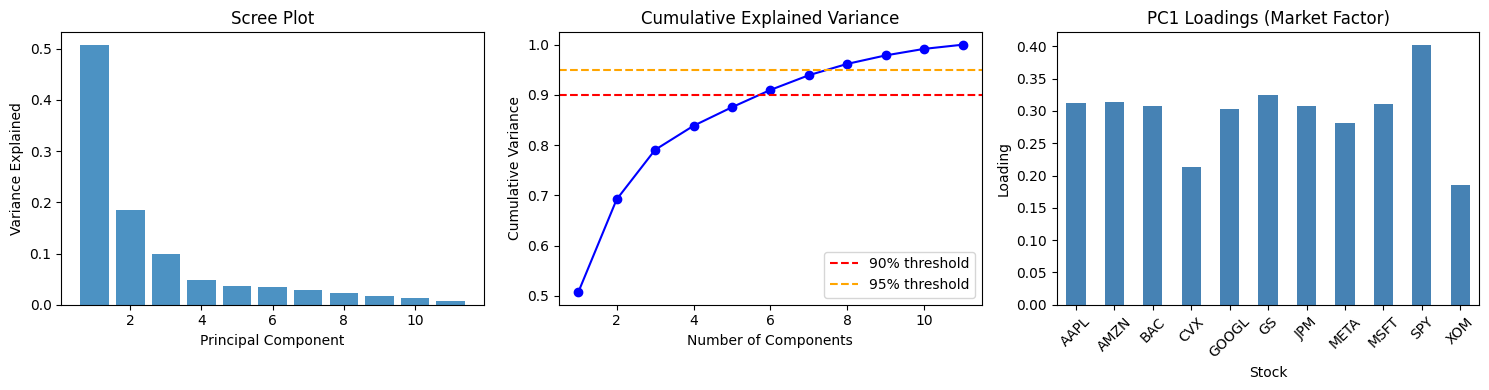


📊 Number of components for 90% variance: 6
📊 Number of components for 95% variance: 8


In [2]:
# Apply PCA to stock returns
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns)

# Fit PCA
pca = PCA()
pca.fit(returns_scaled)

# Explained variance
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

print("PCA Results - Stock Return Factors")
print("="*60)
print(f"\nVariance explained by top components:")
for i in range(min(5, len(exp_var))):
    print(f"  PC{i+1}: {exp_var[i]:.1%} (cumulative: {cum_var[i]:.1%})")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Scree plot
axes[0].bar(range(1, len(exp_var)+1), exp_var, alpha=0.8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Scree Plot')

# Cumulative variance
axes[1].plot(range(1, len(cum_var)+1), cum_var, 'bo-')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()

# PC1 loadings (factor exposures)
loadings = pd.DataFrame(
    pca.components_[:3].T,
    index=returns.columns,
    columns=['PC1', 'PC2', 'PC3']
)
loadings['PC1'].plot(kind='bar', ax=axes[2], color='steelblue')
axes[2].set_xlabel('Stock')
axes[2].set_ylabel('Loading')
axes[2].set_title('PC1 Loadings (Market Factor)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n📊 Number of components for 90% variance: {np.argmax(cum_var >= 0.90) + 1}")
print(f"📊 Number of components for 95% variance: {np.argmax(cum_var >= 0.95) + 1}")

Factor Interpretation - Top 3 PCs

PC1 (Market Factor) - All positive = market beta:
Ticker
SPY      0.402
GS       0.325
AMZN     0.314
AAPL     0.312
MSFT     0.311
BAC      0.308
JPM      0.308
GOOGL    0.303
META     0.281
CVX      0.213
XOM      0.185
Name: PC1_Market, dtype: float64

PC2 - Positive vs Negative = Long/Short factor:
Ticker
XOM      0.485
CVX      0.459
BAC      0.286
JPM      0.266
GS       0.215
SPY     -0.077
AAPL    -0.190
AMZN    -0.258
GOOGL   -0.266
META    -0.281
MSFT    -0.311
Name: PC2, dtype: float64


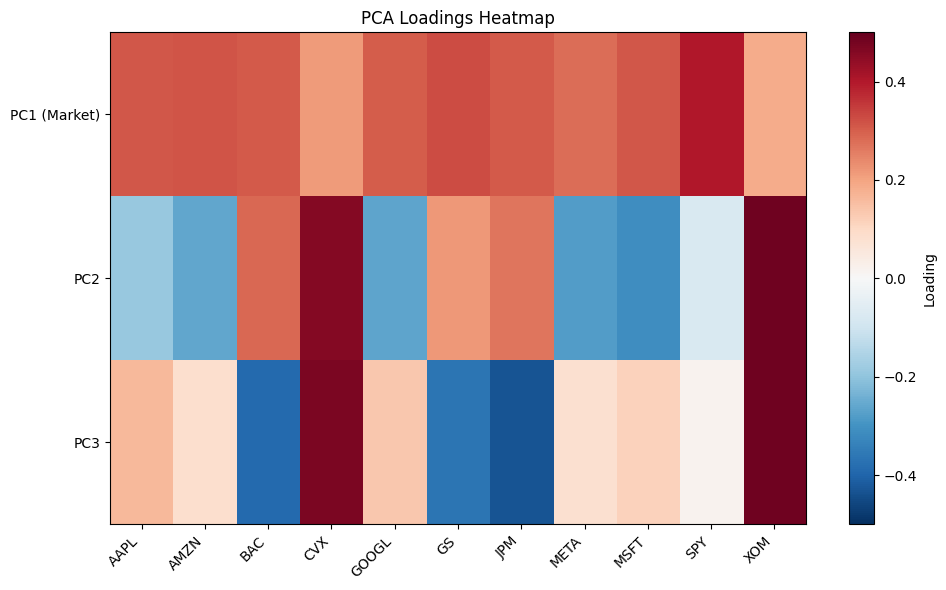

In [3]:
# Analyze PC loadings for interpretation
print("Factor Interpretation - Top 3 PCs")
print("="*60)

loadings = pd.DataFrame(
    pca.components_[:3].T,
    index=returns.columns,
    columns=['PC1_Market', 'PC2', 'PC3']
)

print("\nPC1 (Market Factor) - All positive = market beta:")
print(loadings['PC1_Market'].sort_values(ascending=False).round(3))

print("\nPC2 - Positive vs Negative = Long/Short factor:")
print(loadings['PC2'].sort_values(ascending=False).round(3))

# Visualize loadings as a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(loadings.T, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
ax.set_xticks(range(len(loadings.index)))
ax.set_xticklabels(loadings.index, rotation=45, ha='right')
ax.set_yticks(range(3))
ax.set_yticklabels(['PC1 (Market)', 'PC2', 'PC3'])
ax.set_title('PCA Loadings Heatmap')
plt.colorbar(im, ax=ax, label='Loading')
plt.tight_layout()
plt.show()

---

## 2. K-Means Clustering

### 🤔 Simple Explanation

K-Means groups similar data points into k clusters by:
1. Initialize k cluster centers
2. Assign points to nearest center
3. Update centers as mean of cluster
4. Repeat until convergence

**Objective:**
$$\min_{C} \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$$

### Finance Application: Market Regime Detection
- Cluster days by volatility, momentum, correlation
- Identify bull/bear/sideways regimes

In [4]:
# Create market regime features
regime_data = pd.DataFrame(index=returns.index)

# Volatility (using SPY as market proxy)
regime_data['volatility'] = returns['SPY'].rolling(20).std() * np.sqrt(252)

# Momentum
regime_data['momentum'] = prices['SPY'].pct_change(20)

# Average correlation (market stress indicator)
corr_matrix = returns.rolling(20).corr()
# Get average pairwise correlation
avg_corr = []
for date in returns.index:
    if date in corr_matrix.index.get_level_values(0):
        try:
            daily_corr = corr_matrix.loc[date]
            # Get upper triangle (excluding diagonal)
            mask = np.triu(np.ones_like(daily_corr, dtype=bool), k=1)
            avg_corr.append(daily_corr.values[mask].mean())
        except:
            avg_corr.append(np.nan)
    else:
        avg_corr.append(np.nan)

regime_data['avg_correlation'] = avg_corr
regime_data = regime_data.dropna()

print(f"Regime features: {len(regime_data)} days")
print(regime_data.describe().round(4))

Regime features: 1235 days
       volatility   momentum  avg_correlation
count   1235.0000  1235.0000        1235.0000
mean       0.1546     0.0114           0.3942
std        0.0765     0.0415           0.1661
min        0.0542    -0.1204           0.0229
25%        0.1029    -0.0114           0.2709
50%        0.1361     0.0186           0.3784
75%        0.1830     0.0380           0.5023
max        0.5454     0.1576           0.8619


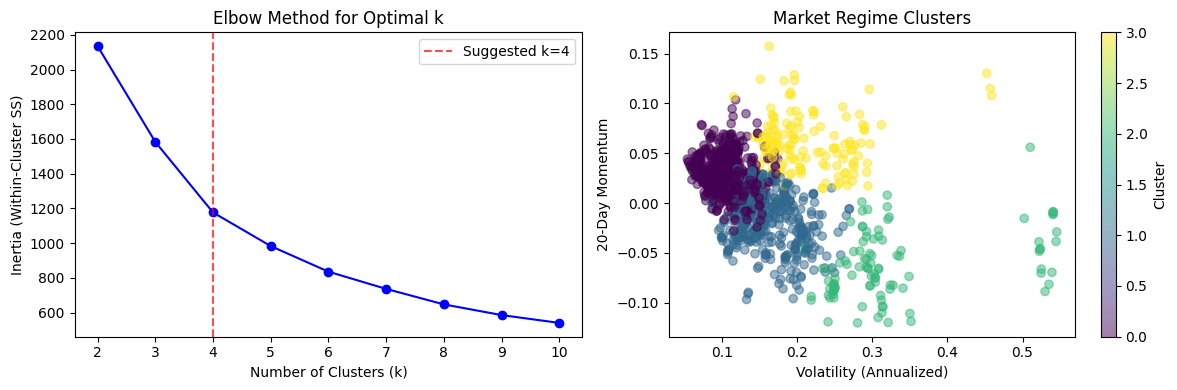

In [5]:
# Scale features
scaler_regime = StandardScaler()
X_regime = scaler_regime.fit_transform(regime_data)

# Elbow method to find optimal k
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_regime)
    inertias.append(kmeans.inertia_)

# Plot elbow
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-Cluster SS)')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].axvline(x=4, color='r', linestyle='--', alpha=0.7, label='Suggested k=4')
axes[0].legend()

# Apply K-Means with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_regime)
regime_data['cluster'] = clusters

# Visualize clusters
scatter = axes[1].scatter(regime_data['volatility'], regime_data['momentum'], 
                          c=clusters, cmap='viridis', alpha=0.5)
axes[1].set_xlabel('Volatility (Annualized)')
axes[1].set_ylabel('20-Day Momentum')
axes[1].set_title('Market Regime Clusters')
plt.colorbar(scatter, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

Market Regime Analysis

🟢 Bull Market (Cluster 0): 566 days (45.8%)
  Avg Volatility: 10.5%
  Avg Momentum: 3.10%
  Avg Correlation: 0.26

🟡 Sideways/Low Vol (Cluster 1): 423 days (34.3%)
  Avg Volatility: 16.0%
  Avg Momentum: -1.48%
  Avg Correlation: 0.45

🔴 Crisis/High Vol (Cluster 2): 99 days (8.0%)
  Avg Volatility: 32.8%
  Avg Momentum: -6.13%
  Avg Correlation: 0.71

🟠 Volatile Rally (Cluster 3): 147 days (11.9%)
  Avg Volatility: 21.4%
  Avg Momentum: 6.07%
  Avg Correlation: 0.54


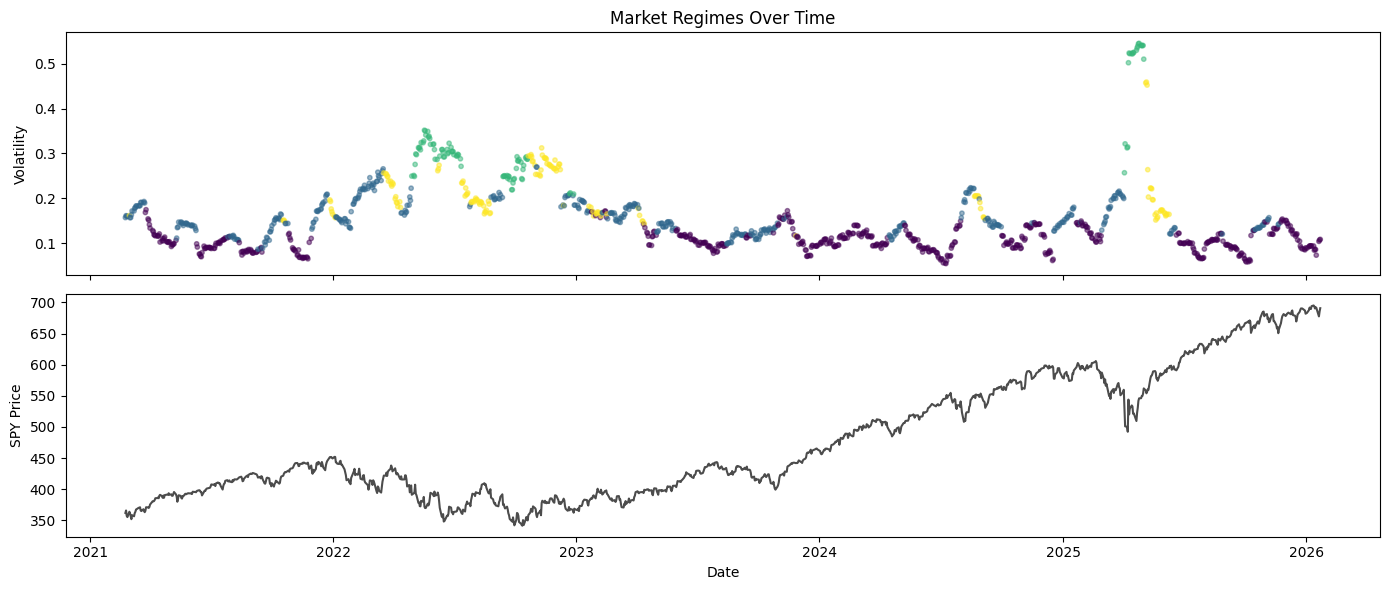

In [6]:
# Analyze clusters (regimes)
print("Market Regime Analysis")
print("="*60)

# Name the regimes based on characteristics
regime_names = {}
cluster_stats = regime_data.groupby('cluster').agg({
    'volatility': 'mean',
    'momentum': 'mean',
    'avg_correlation': 'mean'
})

# Assign names based on characteristics
for cluster in range(4):
    vol = cluster_stats.loc[cluster, 'volatility']
    mom = cluster_stats.loc[cluster, 'momentum']
    
    if vol > cluster_stats['volatility'].median():
        if mom < 0:
            name = "🔴 Crisis/High Vol"
        else:
            name = "🟠 Volatile Rally"
    else:
        if mom > 0:
            name = "🟢 Bull Market"
        else:
            name = "🟡 Sideways/Low Vol"
    
    regime_names[cluster] = name

for cluster in range(4):
    mask = regime_data['cluster'] == cluster
    print(f"\n{regime_names[cluster]} (Cluster {cluster}): {mask.sum()} days ({mask.sum()/len(regime_data)*100:.1f}%)")
    print(f"  Avg Volatility: {regime_data.loc[mask, 'volatility'].mean():.1%}")
    print(f"  Avg Momentum: {regime_data.loc[mask, 'momentum'].mean():.2%}")
    print(f"  Avg Correlation: {regime_data.loc[mask, 'avg_correlation'].mean():.2f}")

# Plot regime timeline
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Regime over time
colors = ['green', 'red', 'orange', 'gray']
regime_data['regime_color'] = regime_data['cluster'].map({i: colors[i] for i in range(4)})

axes[0].scatter(regime_data.index, regime_data['volatility'], 
               c=regime_data['cluster'], cmap='viridis', alpha=0.5, s=10)
axes[0].set_ylabel('Volatility')
axes[0].set_title('Market Regimes Over Time')

# SPY price with regime coloring
spy_aligned = prices['SPY'].loc[regime_data.index]
axes[1].plot(spy_aligned.index, spy_aligned.values, 'k-', alpha=0.7)
axes[1].set_ylabel('SPY Price')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

---

## 3. Hierarchical Clustering

### 🤔 Simple Explanation

Hierarchical clustering builds a tree of clusters:
- **Agglomerative**: Start with each point as cluster, merge upward
- **Dendrogram**: Visualizes the hierarchy

### Finance Application: Asset Grouping
- Find which stocks naturally group together
- Build sector-neutral portfolios

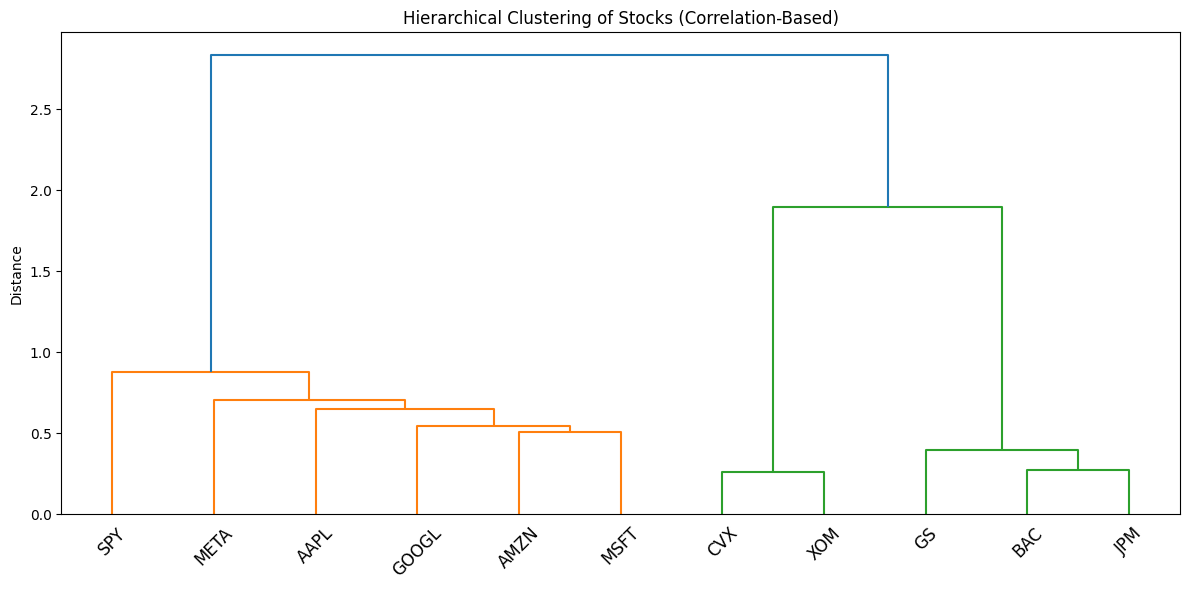


Stock Clusters:
AAPL: Cluster 1
AMZN: Cluster 1
BAC: Cluster 3
CVX: Cluster 2
GOOGL: Cluster 1
GS: Cluster 3
JPM: Cluster 3
META: Cluster 1
MSFT: Cluster 1
SPY: Cluster 1
XOM: Cluster 2


In [7]:
# Hierarchical clustering on stock returns
# Use correlation as distance metric
returns_for_clustering = returns.dropna()

# Compute correlation matrix and convert to distance
corr_matrix = returns_for_clustering.corr()
distance_matrix = 1 - corr_matrix  # Convert correlation to distance

# Linkage
Z = linkage(distance_matrix, method='ward')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(12, 6))
dendrogram(Z, labels=returns.columns.tolist(), leaf_rotation=45)
ax.set_title('Hierarchical Clustering of Stocks (Correlation-Based)')
ax.set_ylabel('Distance')
plt.tight_layout()
plt.show()

# Cut dendrogram at k=3 clusters
from scipy.cluster.hierarchy import fcluster
stock_clusters = fcluster(Z, t=3, criterion='maxclust')

print("\nStock Clusters:")
print("="*40)
for i, (stock, cluster) in enumerate(zip(returns.columns, stock_clusters)):
    print(f"{stock}: Cluster {cluster}")


Cluster Composition:

Cluster 1: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'SPY']
  Average intra-cluster correlation: 0.630

Cluster 2: ['CVX', 'XOM']
  Average intra-cluster correlation: 0.854

Cluster 3: ['BAC', 'GS', 'JPM']
  Average intra-cluster correlation: 0.779


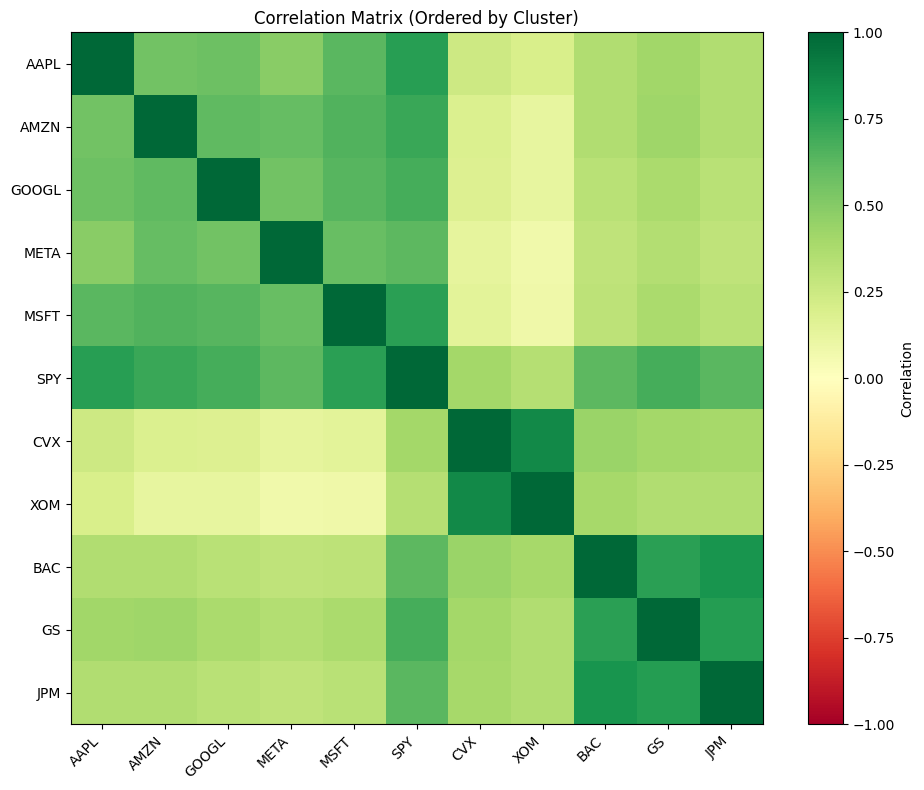

In [8]:
# Analyze stock clusters
cluster_df = pd.DataFrame({
    'Stock': returns.columns,
    'Cluster': stock_clusters
})

print("\nCluster Composition:")
print("="*60)
for cluster in sorted(cluster_df['Cluster'].unique()):
    stocks_in_cluster = cluster_df[cluster_df['Cluster'] == cluster]['Stock'].tolist()
    print(f"\nCluster {cluster}: {stocks_in_cluster}")
    
    # Calculate average correlation within cluster
    if len(stocks_in_cluster) > 1:
        cluster_returns = returns[stocks_in_cluster]
        cluster_corr = cluster_returns.corr()
        mask = np.triu(np.ones_like(cluster_corr, dtype=bool), k=1)
        avg_intra_corr = cluster_corr.values[mask].mean()
        print(f"  Average intra-cluster correlation: {avg_intra_corr:.3f}")

# Visualize correlation matrix with cluster ordering
cluster_order = cluster_df.sort_values('Cluster')['Stock'].tolist()
sorted_corr = corr_matrix.loc[cluster_order, cluster_order]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(sorted_corr, cmap='RdYlGn', vmin=-1, vmax=1)
ax.set_xticks(range(len(cluster_order)))
ax.set_yticks(range(len(cluster_order)))
ax.set_xticklabels(cluster_order, rotation=45, ha='right')
ax.set_yticklabels(cluster_order)
ax.set_title('Correlation Matrix (Ordered by Cluster)')
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

---

## 4. Anomaly Detection

### 🤔 Simple Explanation

Anomaly detection identifies unusual data points. In finance:
- Unusual trading days
- Market stress detection
- Risk management triggers

### Methods:
- **Isolation Forest**: Isolates anomalies using random trees
- **Z-Score**: Statistical threshold
- **DBSCAN**: Points not belonging to any cluster

---

## 📊 Summary & Key Takeaways

### What We Learned:

1. **PCA**: Reduces dimensions, finds statistical factors
2. **K-Means**: Groups similar market conditions into regimes
3. **Hierarchical Clustering**: Builds tree of asset similarities
4. **Anomaly Detection**: Identifies unusual market conditions

### Trading Applications:

| Method | Use Case |
|--------|----------|
| PCA | Factor models, risk decomposition |
| K-Means | Regime-based trading rules |
| Hierarchical | Portfolio construction, sector analysis |
| Isolation Forest | Risk management triggers |

### Key Insight:
- **90% of variance in stock returns explained by ~3-5 factors**
- First factor is almost always "market" (all stocks move together)

---

## 🔑 Interview Questions

1. **How many principal components should you keep?**
2. **How do you choose k for K-Means?**
3. **What makes Isolation Forest good for finance?**
4. **How would you use clustering for portfolio construction?**

---

---

## 4. Anomaly Detection

### 🤔 Simple Explanation

Anomaly detection identifies unusual data points. In finance:
- Unusual trading days
- Market stress detection
- Risk management triggers

### Methods:
- **Isolation Forest**: Isolates anomalies using random trees
- **Z-Score**: Statistical threshold
- **DBSCAN**: Points not belonging to any cluster